### Clustering of sleep text scores using OpenAI Text Embedding

#### Import libraries  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### Setup working directory

In [6]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Documents/ds2024/dsF1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Documents/ds2024/dsF1


#### Parameters  

In [7]:
csv_in = 'sleep-text-score.csv'

#### Read CSV file  

In [9]:
df = pd.read_csv(csv_in, sep=',', skiprows=0, header=0, encoding='shift-jis')
print(df.shape)
print(df.info())
display(df.head())

(426, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               426 non-null    object
 1   GPT-4o             426 non-null    int64 
 2   Gemini-1.5-Pro     426 non-null    int64 
 3   Claude-3.5-Sonnet  426 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 13.4+ KB
None


,text,GPT-4o,Gemini-1.5-Pro,Claude-3.5-Sonnet
0,就寝時間を毎日一定にする,2,2,2
1,朝日を積極的に浴びる,2,2,2
2,寝室の温度を18-22度に保つ,2,2,2
3,就寝前のストレッチで体をリラックスさせる,2,2,2
4,寝具は定期的に清潔に保つ,2,2,2


In [10]:
df = df[['text', 'GPT-4o']]
print(df.shape)
print(df.info())
display(df.head())

(426, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    426 non-null    object
 1   GPT-4o  426 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.8+ KB
None


,text,GPT-4o
0,就寝時間を毎日一定にする,2
1,朝日を積極的に浴びる,2
2,寝室の温度を18-22度に保つ,2
3,就寝前のストレッチで体をリラックスさせる,2
4,寝具は定期的に清潔に保つ,2


#### Check the number of documents in each category  

In [11]:
print(df['GPT-4o'].value_counts().sort_index(ascending=True))

GPT-4o
0    164
1     61
2    201
Name: count, dtype: int64


#### Load vecs

In [16]:
vecs = np.load(vecs_out)

In [17]:
print(vecs.shape)

(426, 1536)


#### Elbow method to determine the number of clusters  

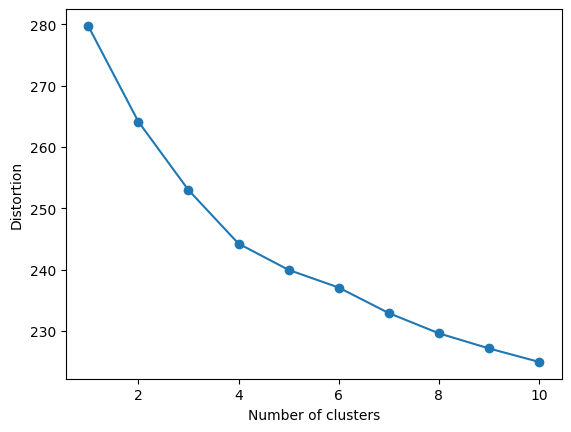

CPU times: user 6.42 s, sys: 2.14 s, total: 8.55 s
Wall time: 24.1 s


In [19]:
%%time

max_cls = 10
distortions = []
for i in range(1, max_cls+1):
    km = KMeans(n_clusters=i, n_init=10)
    km.fit(vecs)
    distortions.append(km.inertia_)
plt.plot(range(1, max_cls+1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

#### K-Means clustering  

In [20]:
n_cls = 3
km = KMeans(n_clusters=n_cls, n_init=10, random_state=7)
cls = km.fit_predict(vecs)

#### Check correspondence of target and clusters  

In [21]:
display(pd.crosstab(df['GPT-4o'], cls))

col_0,0,1,2
GPT-4o,,,
0,38,58,68
1,9,24,28
2,40,100,61


#### PCA  

In [22]:
%%time

pca = PCA(n_components=2)
Y_pca = pca.fit_transform(vecs)

CPU times: user 151 ms, sys: 23.5 ms, total: 175 ms
Wall time: 569 ms


#### Check contribution ratio  

In [23]:
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

[0.06595892 0.05827098]
[0.06595892 0.1242299 ]


#### Plot of PCA colored by cluster ID

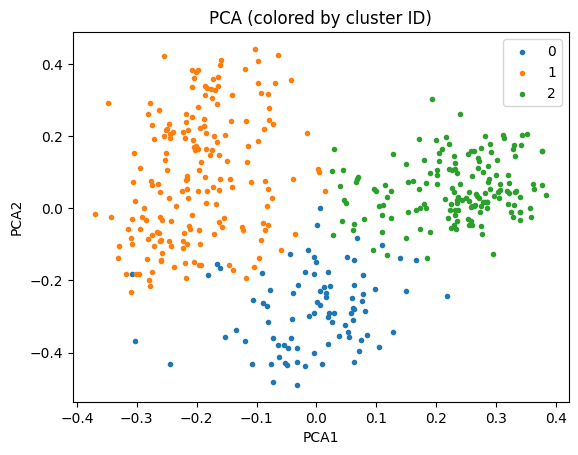

In [24]:
plt.title("PCA (colored by cluster ID)")
marker = '.'
for i in range(n_cls):
    y1 = Y_pca[ cls==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

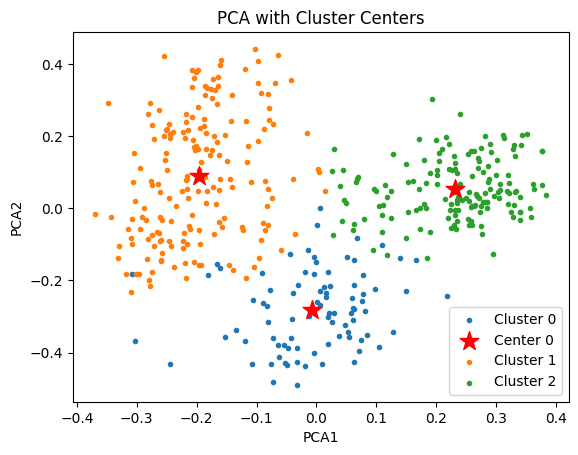


Cluster 0 - Texts near center (within distance 0.05):
--------------------------------------------------------------------------------
Distance 0.009: 寝室での仕事関連の書類整理
Distance 0.018: 寝室でペットと過ごす
Distance 0.019: 寝室を暗くする
Distance 0.023: 室温が低すぎるまたは高すぎる状態で寝る
Distance 0.029: 寝室に時計を置く
Distance 0.032: 部屋を軽く香り付けして寝る
Distance 0.039: 寝室でリラックス音楽を聴く
Distance 0.041: 寝室での静かな音楽
Distance 0.042: 寝室の明るさを調整せずに寝る
Distance 0.047: 寝室での穏やかな瞑想

Cluster 1 - Texts near center (within distance 0.05):
--------------------------------------------------------------------------------
Distance 0.011: ハーブティーを飲む
Distance 0.017: マグネシウムを多く含むアーモンドなどのナッツ類を間食に取り入れる
Distance 0.020: アルコールを摂取する
Distance 0.021: 早朝の公園を少しだけジョギングする
Distance 0.025: 明日の仕事のことを心配する
Distance 0.036: 午前中にアウトドア活動をする
Distance 0.038: ビデオゲームを長時間プレイする
Distance 0.040: ビタミンDを摂取する
Distance 0.041: 明日への楽しい計画を立てる
Distance 0.041: 軽いエクササイズを昼間に取り入れる
Distance 0.044: 明日のプレゼンテーションの不安で頭がいっぱいになる
Distance 0.050: 明日の嫌な予定を考え込む

Cluster 2 - Texts near center (within distance 0.0

In [37]:
def find_texts_near_center_pca(pca_coords, texts, labels, cluster_id, distance_threshold):
    # Get points for the specified cluster
    cluster_mask = labels == cluster_id
    cluster_coords = pca_coords[cluster_mask]
    cluster_texts = texts[cluster_mask]

    # Find cluster center
    center = np.mean(cluster_coords, axis=0)

    # Calculate distances from center
    distances = np.sqrt(np.sum((cluster_coords - center) ** 2, axis=1))

    # Find points within threshold
    nearby_mask = distances <= distance_threshold
    nearby_texts = cluster_texts[nearby_mask]
    nearby_distances = distances[nearby_mask]

    # Sort by distance
    sorted_indices = np.argsort(nearby_distances)
    sorted_texts = nearby_texts[sorted_indices]
    sorted_distances = nearby_distances[sorted_indices]

    return sorted_texts, sorted_distances, center

# Convert texts to numpy array for indexing
texts_array = np.array(df['text'])

# Plot PCA with cluster centers
plt.title("PCA with Cluster Centers")
marker = '.'

for i in range(n_cls):
    y1 = Y_pca[cls==i]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=f'Cluster {i}')

    # Find and plot cluster center
    center = np.mean(y1, axis=0)
    plt.scatter(center[0], center[1], marker='*', s=200,
               c='red', label=f'Center {i}' if i==0 else "")

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Find nearby texts for each cluster
# Note: You might need to adjust the distance threshold for PCA
# as the scale might be different from t-SNE
distance_threshold = 0.05  # Adjust this value based on your PCA scale

for cluster_id in range(n_cls):
    print(f"\nCluster {cluster_id} - Texts near center (within distance {distance_threshold}):")
    print("-" * 80)

    nearby_texts, distances, center = find_texts_near_center_pca(
        Y_pca, texts_array, cls, cluster_id, distance_threshold
    )

    for text, dist in zip(nearby_texts, distances):
        print(f"Distance {dist:.3f}: {text}")

LLMは文章の先を見ている（だから何なのか）  
Clusteringは文章そのものを見ている（Cluster0: 寝室, Cluster2: 就寝前, Cluster1: それ以外）

#### Plot of PCA colored by target  

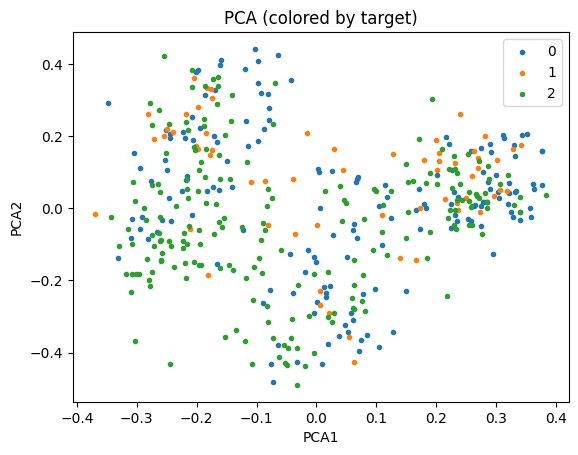

In [25]:
#plt.figure(figsize=(10,7))
plt.title("PCA (colored by target)")
marker = '.'
for i in range(n_cls):
    y1 = Y_pca[ df['GPT-4o']==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

#### t-SNE  

In [26]:
%%time

Y_tsne = TSNE(n_components=2,
              perplexity=30, n_iter=500,
              random_state=0).fit_transform(vecs)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


CPU times: user 3.03 s, sys: 63.9 ms, total: 3.1 s
Wall time: 5.05 s


#### Plot of t-SNE colored by cluster ID

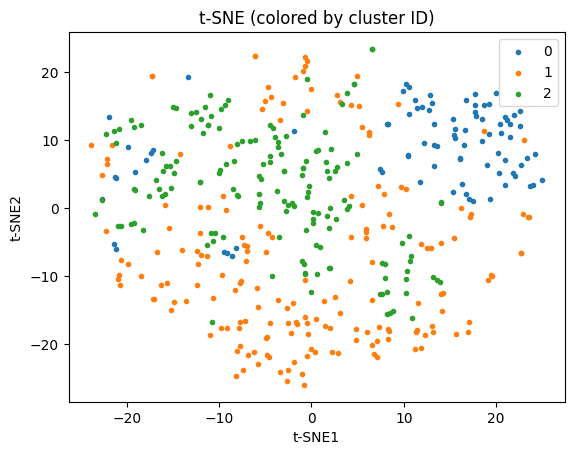

In [27]:
#plt.figure(figsize=(10,7))
plt.title("t-SNE (colored by cluster ID)")
marker = '.'
for i in range(n_cls):
    y1 = Y_tsne[ cls==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()

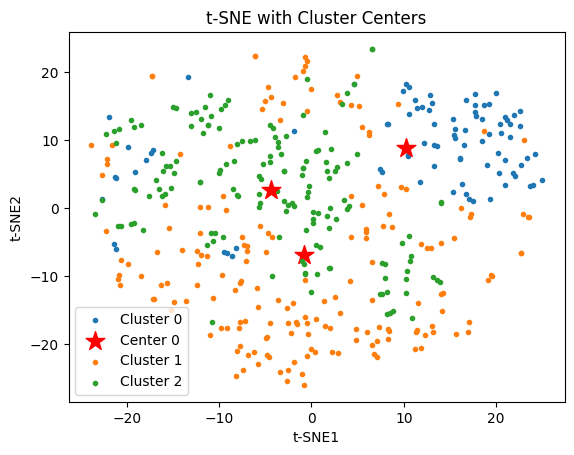


Cluster 0 - Texts near center (within distance 5.0):
--------------------------------------------------------------------------------
Distance 1.01: リビングで少し寝てからベッドに移動する
Distance 1.13: リビングで眠る
Distance 2.07: クローゼットにある服を少し片付けてから寝る
Distance 3.07: 部屋を整理整頓してから寝る
Distance 3.41: 部屋を散らかしたまま睡眠に入る
Distance 4.03: 寝室に時計を置く
Distance 4.04: 外の騒音や光が気になって眠れない
Distance 4.10: 部屋の時計が気になってしまい何度も確認してしまう
Distance 4.13: 寝室での穏やかな会話
Distance 4.39: 寝室での穏やかな瞑想
Distance 4.69: 寝室で洗濯物を干す

Cluster 1 - Texts near center (within distance 5.0):
--------------------------------------------------------------------------------
Distance 3.65: 夕方に長時間の昼寝をする
Distance 4.11: リラックスできるバスタイムを楽しむ
Distance 4.33: 瞑想アプリでリラックス

Cluster 2 - Texts near center (within distance 5.0):
--------------------------------------------------------------------------------
Distance 0.66: 寝る直前までの勉強
Distance 1.48: 寝る前に軽いジャーナリングをする
Distance 1.96: 寝る前に心を穏やかにするアファメーションを唱える
Distance 2.23: 寝る直前に強い運動をする
Distance 2.25: 寝る前に軽い散歩をする
Distance 2.44: 寝る前にチャンツやマント

In [41]:
def find_texts_near_center(tsne_coords, texts, labels, cluster_id, distance_threshold):
    # Get points for the specified cluster
    cluster_mask = labels == cluster_id
    cluster_coords = tsne_coords[cluster_mask]
    cluster_texts = texts[cluster_mask]

    # Find cluster center
    center = np.mean(cluster_coords, axis=0)

    # Calculate distances from center
    distances = np.sqrt(np.sum((cluster_coords - center) ** 2, axis=1))

    # Find points within threshold
    nearby_mask = distances <= distance_threshold
    nearby_texts = cluster_texts[nearby_mask]
    nearby_distances = distances[nearby_mask]

    # Sort by distance
    sorted_indices = np.argsort(nearby_distances)
    sorted_texts = nearby_texts[sorted_indices]
    sorted_distances = nearby_distances[sorted_indices]

    return sorted_texts, sorted_distances, center

# Convert texts to numpy array for indexing
texts_array = np.array(df['text'])

# Plot t-SNE with cluster centers
plt.title("t-SNE with Cluster Centers")
marker = '.'

for i in range(n_cls):
    y1 = Y_tsne[cls==i]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=f'Cluster {i}')

    # Find and plot cluster center
    center = np.mean(y1, axis=0)
    plt.scatter(center[0], center[1], marker='*', s=200,
               c='red', label=f'Center {i}' if i==0 else "")

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()

# Find nearby texts for each cluster
distance_threshold = 5.0  # Adjust this value to control the radius

for cluster_id in range(n_cls):
    print(f"\nCluster {cluster_id} - Texts near center (within distance {distance_threshold}):")
    print("-" * 80)

    nearby_texts, distances, center = find_texts_near_center(
        Y_tsne, texts_array, cls, cluster_id, distance_threshold
    )

    for text, dist in zip(nearby_texts, distances):
        print(f"Distance {dist:.2f}: {text}")

#### Plot of t-SNE colored by target  

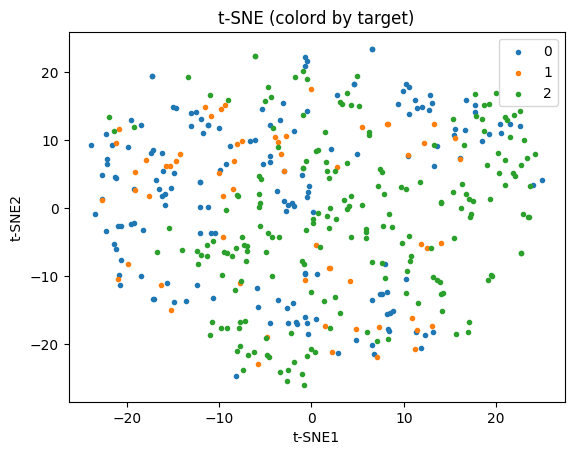

In [28]:
#plt.figure(figsize=(10,7))
plt.title("t-SNE (colord by target)")
marker = '.'
for i in range(n_cls):
    y1 = Y_tsne[ df['GPT-4o']==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()